# What's Cooking? 
Description: This notebook performs supervised learning on the "What's Cooking?" dataset.
Models: 
• Logistic Regression 
• SVM
• Random Forest
• K-nearest neighbor
• Naive Bayes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from collections import Counter
import copy as cp
import pickle
import math


%matplotlib inline
pd.options.display.max_columns=100

## Helper functions

In [2]:
def splitTrainingTesting(X):
    """Split into trained and test sets"""
    df_test = X.sample(frac=.2, random_state=3) 
    df_train = X.drop(df_test.index)
    return df_test, df_train

## Load data 

In [3]:
# Load data and create BOW

data = pd.read_json('train.json')
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)
dataBinaryIngredients.head()


,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,"2 1/2 to 3 lb. chicken, cut into serving pieces",2% low fat cheddar chees,2% low-fat cottage cheese,2% lowfat greek yogurt,2% milk shredded mozzarella cheese,2% reduced-fat milk,25% less sodium chicken broth,33% less sodium cooked deli ham,33% less sodium cooked ham,33% less sodium ham,33% less sodium smoked fully cooked ham,40% less sodium taco seasoning,40% less sodium taco seasoning mix,7 Up,"8 ounc ziti pasta, cook and drain",95% lean ground beef,A Taste of Thai Rice Noodles,Accent Seasoning,Adobo All Purpose Seasoning,Alaskan king crab legs,Alexia Waffle Fries,Alfredo sauce,Amarena cherries,Amaretti Cookies,American cheese,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,Asian sweet chili sauce,Azteca Flour Tortillas,BACARDI® Mixers Margarita Mix,BACARDI® Superior,BREAKSTONE'S Sour Cream,Baileys Irish Cream Liqueur,Balsamico Bianco,Barilla Linguine,Barilla Oven-Ready Lasagne,Barilla Plus Pasta,...,yellow chives,yellow corn,yellow corn meal,yellow crookneck squash,yellow curry paste,yellow food coloring,yellow heirloom tomatoes,yellow hominy,yellow lentils,yellow miso,yellow mustard,yellow mustard seeds,yellow onion,yellow peas,yellow peppers,yellow rice,yellow rock sugar,yellow split peas,yellow squash,yellow summer squash,yellow tomato,yellowfin,yellowfin tuna,yellowtail,yellowtail snapper fillets,yoghurt,yoghurt natural low fat,yogurt cheese,yogurt dressing,yogurt low fat,yolk,yoplait,young coconut meat,young leeks,young nettle,yu choy,yuca,yucca,yucca root,yukon gold,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
%%time



def create_tf_idf_df(dataBinaryIngredients):
    """
    Creates tf-idf dataframe from input. 
    1. Normalize TF matrix
    2. Create idf 
    3. Create tf-idf matrix
    4. Make tf-idf matrix into pandas dataframe and save 
    """
    ## 1. Normalize TF matrix 
    n_ingredients = dataBinaryIngredients.shape[1]
    n_recipes = dataBinaryIngredients.shape[0]

    binaryIngredientsMatNorm = cp.deepcopy(binaryIngredientsMat)

    for row in range(0,n_recipes):
        row_sum = binaryIngredientsMat[row,:].sum()
        binaryIngredientsMatNorm[row,:] = binaryIngredientsMat[row,:]/row_sum


    ## 2. Create idf 
    # Each ingredient will have an IDF
    idf = np.zeros(len(ingredientList))
    for ingredient in range(0,n_ingredients):
        n_recipes_with_that_ingredient = binaryIngredientsMat[:,ingredient].sum()
        idf[ingredient] = math.log( n_recipes / n_recipes_with_that_ingredient )
       
    ## 3. Create tf-idf matrix
    # Calculate TF-IDF for every term:
    tf_idf_mat = cp.deepcopy(binaryIngredientsMatNorm)

    for ingredient in range(0,n_ingredients):
        tf_idf_mat[:,ingredient] = binaryIngredientsMatNorm[:,ingredient]*idf[ingredient]
        #if ingredient % 1000 == 0:
        #    print(tf_idf[:,ingredient])

    # 4. Make tf-idf matrix into pandas dataframe and save
    pd.options.display.max_columns=200
    tf_idf = pd.DataFrame(tf_idf_mat, columns=ingredientList)
    tf_idf.to_pickle("tf_idf.pkl")
    return tf_idf


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [5]:
a = create_tf_idf_df(dataBinaryIngredients)

In [6]:
a['salt'].head()

0    0.000000
1    0.071834
2    0.065848
3    0.197545
4    0.039509
Name: salt, dtype: float64

In [7]:
a.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,"2 1/2 to 3 lb. chicken, cut into serving pieces",2% low fat cheddar chees,2% low-fat cottage cheese,2% lowfat greek yogurt,2% milk shredded mozzarella cheese,2% reduced-fat milk,25% less sodium chicken broth,33% less sodium cooked deli ham,33% less sodium cooked ham,33% less sodium ham,33% less sodium smoked fully cooked ham,40% less sodium taco seasoning,40% less sodium taco seasoning mix,7 Up,"8 ounc ziti pasta, cook and drain",95% lean ground beef,A Taste of Thai Rice Noodles,Accent Seasoning,Adobo All Purpose Seasoning,Alaskan king crab legs,Alexia Waffle Fries,Alfredo sauce,Amarena cherries,Amaretti Cookies,American cheese,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,Asian sweet chili sauce,Azteca Flour Tortillas,BACARDI® Mixers Margarita Mix,BACARDI® Superior,BREAKSTONE'S Sour Cream,Baileys Irish Cream Liqueur,Balsamico Bianco,Barilla Linguine,Barilla Oven-Ready Lasagne,Barilla Plus Pasta,Bartlett Pear,Belgian endive,Bengali 5 Spice,Bertolli Garlic Alfredo Sauce,Bertolli Tomato & Basil Sauce,Bertolli® Alfredo Sauce,Bertolli® Arrabbiata Sauce,Bertolli® Classico Olive Oil,Best Food's Mayonnaise with Lime Juice,Best Foods® Real Mayonnaise,Better Than Bouillon Chicken Base,Betty Crocker™ oatmeal cookie mix,Biryani Masala,Bisquick Baking Mix,Bisquick Original All-Purpose Baking Mix,Bob Evans Italian Sausage,Bordelaise sauce,Boston lettuce,Boursin,Braeburn Apple,Bragg Liquid Aminos,Breakstone’s Sour Cream,Breyers® Natural Vanilla Ice Cream,Budweiser,Burgundy wine,CURRY GUY Smoked Garam Masala,CURRY GUY Smoked Spicy Salt,California bay leaves,Camellia Red Kidney Beans,Campbell's Condensed Cheddar Cheese Soup,Campbell's Condensed Cream of Chicken Soup,Campbell's Condensed Cream of Mushroom Soup,Campbell's Condensed Tomato Soup,Cara Cara orange,Castelvetrano olives,Cavenders Greek Seasoning,Challenge Butter,Chambord Liqueur,Chartreuse Liqueur,Chianti,Chinese egg noodles,Chinese rice vinegar,Chinese rose wine,Chinese sesame paste,Cholula Hot Sauce,Ciabatta rolls,Cinnamon Toast Crunch Cereal,Classico Pasta Sauce,Cointreau Liqueur,Colman's Mustard Powder,...,whole wheat tortilla wraps,whole wheat tortillas,whole wheat uncooked lasagna noodles,wholemeal flour,wide egg noodles,wide rice noodles,wieners,wild asparagus,wild garlic,wild mushrooms,wild rice,wild salmon,wildflower honey,wine,wine syrup,wine vinegar,winesap,wing sauce,winter melon,winter savory,winter squash,wish bone guacamol ranch dress,wish bone ranch dress,wish bone red wine vinaigrett dress,wish-bone,wish-bone light asian sesame ginger vinaigrette dressing,wish-bone light country italian dressing,won ton skins,won ton wrappers,wondra,wondra flour,wonton noodles,wonton skins,wonton wrappers,wood ear mushrooms,wood mushrooms,worcestershire sauce,worcestershire sauce low sodium,xanthan gum,xuxu,yaki-nori,yam bean,yam noodles,yams,yardlong beans,yeast,yeast extract,yellow bean sauce,yellow bell pepper,yellow cake mix,yellow chives,yellow corn,yellow corn meal,yellow crookneck squash,yellow curry paste,yellow food coloring,yellow heirloom tomatoes,yellow hominy,yellow lentils,yellow miso,yellow mustard,yellow mustard seeds,yellow onion,yellow peas,yellow peppers,yellow rice,yellow rock sugar,yellow split peas,yellow squash,yellow summer squash,yellow tomato,yellowfin,yellowfin tuna,yellowtail,yellowtail snapper fillets,yoghurt,yoghurt natural low fat,yogurt cheese,yogurt dressing,yogurt low fat,yolk,yoplait,young coconut meat,young leeks,young nettle,yu choy,yuca,yucca,yucca root,yukon gold,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Supervised learning (adapted from hw2 )

In [8]:
test, train = splitTrainingTesting(dataBinaryIngredients)

In [9]:
train_ids = train.index.values
test_ids = test.index.values

In [10]:
# begin with Logistic Regression
trainLabels = data.loc[train_ids, 'cuisine'].values
testLabels = data.loc[test_ids, 'cuisine'].values 




In [11]:
train.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,1% low-fat milk,"2 1/2 to 3 lb. chicken, cut into serving pieces",2% low fat cheddar chees,2% low-fat cottage cheese,2% lowfat greek yogurt,2% milk shredded mozzarella cheese,2% reduced-fat milk,25% less sodium chicken broth,33% less sodium cooked deli ham,33% less sodium cooked ham,33% less sodium ham,33% less sodium smoked fully cooked ham,40% less sodium taco seasoning,40% less sodium taco seasoning mix,7 Up,"8 ounc ziti pasta, cook and drain",95% lean ground beef,A Taste of Thai Rice Noodles,Accent Seasoning,Adobo All Purpose Seasoning,Alaskan king crab legs,Alexia Waffle Fries,Alfredo sauce,Amarena cherries,Amaretti Cookies,American cheese,Anaheim chile,Angostura bitters,Argo Corn Starch,Asian chili sauce,Asian sweet chili sauce,Azteca Flour Tortillas,BACARDI® Mixers Margarita Mix,BACARDI® Superior,BREAKSTONE'S Sour Cream,Baileys Irish Cream Liqueur,Balsamico Bianco,Barilla Linguine,Barilla Oven-Ready Lasagne,Barilla Plus Pasta,Bartlett Pear,Belgian endive,Bengali 5 Spice,Bertolli Garlic Alfredo Sauce,Bertolli Tomato & Basil Sauce,Bertolli® Alfredo Sauce,Bertolli® Arrabbiata Sauce,Bertolli® Classico Olive Oil,Best Food's Mayonnaise with Lime Juice,Best Foods® Real Mayonnaise,Better Than Bouillon Chicken Base,Betty Crocker™ oatmeal cookie mix,Biryani Masala,Bisquick Baking Mix,Bisquick Original All-Purpose Baking Mix,Bob Evans Italian Sausage,Bordelaise sauce,Boston lettuce,Boursin,Braeburn Apple,Bragg Liquid Aminos,Breakstone’s Sour Cream,Breyers® Natural Vanilla Ice Cream,Budweiser,Burgundy wine,CURRY GUY Smoked Garam Masala,CURRY GUY Smoked Spicy Salt,California bay leaves,Camellia Red Kidney Beans,Campbell's Condensed Cheddar Cheese Soup,Campbell's Condensed Cream of Chicken Soup,Campbell's Condensed Cream of Mushroom Soup,Campbell's Condensed Tomato Soup,Cara Cara orange,Castelvetrano olives,Cavenders Greek Seasoning,Challenge Butter,Chambord Liqueur,Chartreuse Liqueur,Chianti,Chinese egg noodles,Chinese rice vinegar,Chinese rose wine,Chinese sesame paste,Cholula Hot Sauce,Ciabatta rolls,Cinnamon Toast Crunch Cereal,Classico Pasta Sauce,Cointreau Liqueur,Colman's Mustard Powder,...,whole wheat tortilla wraps,whole wheat tortillas,whole wheat uncooked lasagna noodles,wholemeal flour,wide egg noodles,wide rice noodles,wieners,wild asparagus,wild garlic,wild mushrooms,wild rice,wild salmon,wildflower honey,wine,wine syrup,wine vinegar,winesap,wing sauce,winter melon,winter savory,winter squash,wish bone guacamol ranch dress,wish bone ranch dress,wish bone red wine vinaigrett dress,wish-bone,wish-bone light asian sesame ginger vinaigrette dressing,wish-bone light country italian dressing,won ton skins,won ton wrappers,wondra,wondra flour,wonton noodles,wonton skins,wonton wrappers,wood ear mushrooms,wood mushrooms,worcestershire sauce,worcestershire sauce low sodium,xanthan gum,xuxu,yaki-nori,yam bean,yam noodles,yams,yardlong beans,yeast,yeast extract,yellow bean sauce,yellow bell pepper,yellow cake mix,yellow chives,yellow corn,yellow corn meal,yellow crookneck squash,yellow curry paste,yellow food coloring,yellow heirloom tomatoes,yellow hominy,yellow lentils,yellow miso,yellow mustard,yellow mustard seeds,yellow onion,yellow peas,yellow peppers,yellow rice,yellow rock sugar,yellow split peas,yellow squash,yellow summer squash,yellow tomato,yellowfin,yellowfin tuna,yellowtail,yellowtail snapper fillets,yoghurt,yoghurt natural low fat,yogurt cheese,yogurt dressing,yogurt low fat,yolk,yoplait,young coconut meat,young leeks,young nettle,yu choy,yuca,yucca,yucca root,yukon gold,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [12]:
# Initial values 
X_train = train
y_train =trainLabels

X_test = test
y_test = testLabels


In [13]:
data['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [14]:
target_cuisines = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian']


def fct(s):
    return target_cuisines.index(s)

fct = np.vectorize(fct)





In [15]:
fct

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from itertools import count
import seaborn as sn
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [20]:
# Adapted from hw1 @Chris @Lili
'''
Create functions to run the classifiers and store results in 1 variable
'''

# Helpfer function for cross validation
def calcCrossval(model):
    scores = cross_val_score(model, X_train, y_train, cv=3)
    print("Cross Val Training Accuracy: " + str(round(scores.mean(),3)) + ", STD: " + str(round(scores.std()*2,3)))
    return scores

# Create a class that contains a model and all its variables
# In this case, the 'class' is just a variable of a model
# that contains the model's relevant variables such as fpr, tpr, etc. 


class modDetails:    
    # This creates an umbrella variable that stores evaluation metrics, and relevant data for each 
    # classifier:
    def __init__(self, predictionsTrain, predictionsTest, 
                classifier, train_cvscores, training_accuracy, test_accuracy, clf_report, 
                 cm, name):
        self.predictionsTrain = predictionsTrain
        self.predictionsTest = predictionsTest
        self.training_accuracy = training_accuracy
        self.test_accuracy = test_accuracy
        self.classifier = classifier
        self.train_cvscores = train_cvscores
        self.clf_report =  clf_report
        self.cm = cm
        self.name = name

print('done')

def runModel2(model,name):
    print(name + '-'*50 + ' \n')
    
    # Train the Classifier
    # And obtain 10-fold cross validation results of the training
    
    # GMM not used in this implementation. 
    if name.find('GMM') >= 0: # if this is GMM, only fit with X_train
        tt = model.fit(X_train)
    else:
        tt = model.fit(X_train,y_train)
    
    train_cvscores = calcCrossval(model)
    
    print(str(type(tt)))
    
    
    # Calculate classifier accuracy on trained data and test data
    predictionsTrain = tt.predict(X_train)
    predictionsTest = tt.predict(X_test)
    

    training_accuracy = accuracy_score(y_train, predictionsTrain)
    test_accuracy = accuracy_score(y_test, predictionsTest)
    
    cm = confusion_matrix(predictionsTest, y_test)
    clf_report = classification_report(y_test, predictionsTest, target_names=target_cuisines)
    
    print('Training accuracy: ', training_accuracy)
    print('Test accuracy: ', test_accuracy)


  
    # Save results in one umbrella variable of the class modDetails  
    model_info = modDetails(predictionsTrain, predictionsTest, 
                            tt, train_cvscores, training_accuracy, test_accuracy, clf_report, cm,
                            name)
    return model_info

print('done')
            
'''
Run Classifiers
'''


done
done


'\nRun Classifiers\n'

In [21]:
# rf: max_depth = 2 # look at regression hw_1, check out best depths. 
    
    

## Feature Selection

In [22]:
# https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le
def get_feature_names(selector, dataBinaryIngredients):
    """
    Returns feature names from array of indices
    selector: selectKBest 
    dataBinaryIngredients: dataframe
    """
    mask = selector.get_support(indices=True) #list of booleans
    column_names = dataBinaryIngredients.columns
    feature_names = column_names[mask].values
    return feature_names


In [23]:
from sklearn.feature_selection import RFE
# recursive feature elimination (RFE) ### Takes a lot of time 
def fs(model):
    selector = RFE(model, 10, step=1)
    selector.fit(X_train, y_train)
    print('10 most significant variables, with corresponding coefficients')
    index = 0
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            print(i, selector.estimator_.coef_[0][index])
            index = index + 1
            

In [27]:
# Reset to initial values. 
X_train = train
y_train =trainLabels

X_test = test
y_test = testLabels


In [28]:
# get feature names
# mask = selector.get_support(indices= True)

# for i in mask:
#     print(dataBinaryIngredients.iloc[:, i].name)

# X_new.shape

## Dimensionality Reduction

In [29]:
# Reset to initial values. 
X_train = train
y_train =trainLabels

X_test = test
y_test = testLabels

In [30]:
train.shape

(31819, 6714)

In [31]:
# Truncated data 

#pca, source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD#actually using truncated svd instead of pca -- X is too large and sparse for PCA


# number of components 
n_components = 1000
#rescale??? 
scaler = StandardScaler()
XtrainRescaled = scaler.fit_transform(X_train)
XtestRescaled = scaler.transform(X_test)
print('done rescaling')

pca = TruncatedSVD(n_components= n_components)
principalComps = pca.fit_transform(X_train) # new X_train
principalCompsTest = pca.transform(X_test) # new X_test
print('done principal components')

pcaRescaled = TruncatedSVD(n_components=n_components)
principalCompsRescaled = pcaRescaled.fit_transform(XtrainRescaled)
principalCompsRescaledTest = pcaRescaled.transform(XtestRescaled)
print('done principal components rescaled')


done rescaling
done principal components
done principal components rescaled


In [36]:
pca.explained_variance_ratio_.sum() # 0.8978957710784204: 1000 principal components explain 90% of the variance. (We have enough princip componentsn)

0.8978837509164374

In [37]:
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


## Run Models 

In [38]:
# Set data to reduced dims, otherwise takes too long 
print("Initial X_train.shape ", X_train.shape)
print("Initial y_train.shape ", y_train.shape)
print("Initial X_test.shape ", X_test.shape)
print("Inital y_test.shape ", y_test.shape)


Initial X_train.shape  (31819, 1000)
Initial y_train.shape  (31819,)
Initial X_test.shape  (7955, 1000)
Inital y_test.shape  (7955,)


In [39]:
X_train = principalComps
X_test = principalCompsTest
print("New X_train.shape ", X_train.shape)
print("New X_test.shape ", X_test.shape)


New X_train.shape  (31819, 1000)
New X_test.shape  (7955, 1000)


### 1. Logistic Regression

In [ ]:
# %%time
# Goal: Choose C based on cross-val training accuracy. 

# for c in [0.0001, 0.001, 0.01,0.1, 1, 10, 100, 1000]:
#     logregL1 = LogisticRegression(C = c, penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs')
#     score = cross_val_score(logregL1, X_train, y_train, cv= 3)
#     print ('c' + str(c) + ':')
#     print(score)
#     print ('*'*20)

    
# [0.74368481 0.74115058] with 1000 n_components, principalComps, Coefficient = 1, cross_val accuracy at 0.74 
# [0.73626995 0.73599497] with 1000 n_components, principalCompsRescaled, Coefficient = 1, cross_val accuracy at 0.74 


In [40]:
%%time
logregL1 = LogisticRegression(C = 1, penalty = 'l2', multi_class = 'multinomial', solver = 'lbfgs')
logregL1_info = runModel2(logregL1, 'LogRegL1')



LogRegL1-------------------------------------------------- 

Cross Val Training Accuracy: 0.753, STD: 0.003
<class 'sklearn.linear_model.logistic.LogisticRegression'>
Training accuracy:  0.8308872057575662
Test accuracy:  0.7505971087366436
CPU times: user 1min 13s, sys: 2.5 s, total: 1min 16s
Wall time: 40.9 s


In [ ]:
# Visualise 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


Text(0.5,64.6,'Predicted label')

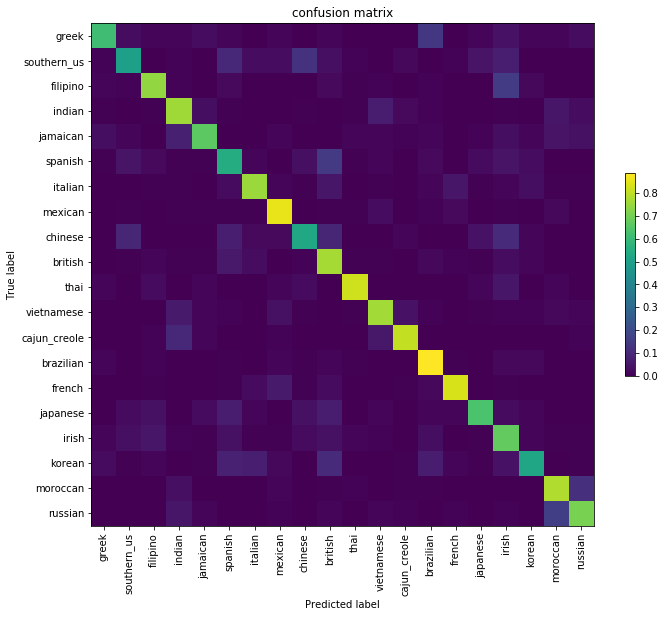

In [45]:
# Plot confusion matrix: https://flothesof.github.io/kaggle-whats-cooking-machine-learning.html?fbclid=IwAR2OXhDXtZ4LRf_K7TO6x2L2d6T3O6-XNtQ1Y4mqTUB1BH7yqGCkaVWiWjM
plt.figure(figsize=(10, 10))

cm = logregL1_info.cm # confusion_matrix(y_test, predictionsTest)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = target_cuisines
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [46]:
# Classification report: Adapted from https://flothesof.github.io/kaggle-whats-cooking-machine-learning.html?fbclid=IwAR2OXhDXtZ4LRf_K7TO6x2L2d6T3O6-XNtQ1Y4mqTUB1BH7yqGCkaVWiWjM
print(logregL1_info.clf_report)

              precision    recall  f1-score   support

       greek       0.61      0.43      0.51        99
 southern_us       0.50      0.35      0.41       155
    filipino       0.74      0.65      0.70       326
      indian       0.76      0.81      0.78       504
    jamaican       0.66      0.60      0.63       142
     spanish       0.55      0.62      0.58       541
     italian       0.75      0.59      0.66       238
     mexican       0.86      0.88      0.87       604
     chinese       0.53      0.36      0.43       141
     british       0.77      0.86      0.81      1542
        thai       0.82      0.57      0.67       106
  vietnamese       0.76      0.65      0.70       294
cajun_creole       0.80      0.71      0.76       156
   brazilian       0.89      0.90      0.89      1280
      french       0.83      0.70      0.76       184
    japanese       0.64      0.48      0.55        97
       irish       0.67      0.78      0.72       880
      korean       0.52    

### 2. XGBoost 

In [ ]:
%%time
from xgboost import XGBClassifier

xgb = XGBClassifier(objective="multi:softprob", random_state=0)
xgb_info = runModel2(xgb, "XG Boost")

### 3. SVM 

In [ ]:
# imports
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

In [ ]:
%%time
# choose different gammas, coefficients
# train SVC
svm = SVC(kernel='linear', random_state=0, gamma=.01, C=1)
svm_info = runModel2(svm, 'SVC linear, C=1')


### 3. RF 

In [ ]:
%%time
rf = RandomForestClassifier(n_estimators=1000, max_depth=100,random_state=0)
rf_info = runModel2(rf, 'Random Forest')

### 4. Gradient Boosting 

In [ ]:
%%time
gbc = GradientBoostingClassifier(n_estimators=1000, max_depth=100,random_state=0)
gbc_info = runModel2(gbc, 'Gradient Boost')

### 5. Naive Bayes

In [47]:
%%time
# Gaussian Naive Bayes Learner
gnb = GaussianNB()
nb_info = runModel2(gnb, 'GaussianNB')

GaussianNB-------------------------------------------------- 

Cross Val Training Accuracy: 0.382, STD: 0.007
<class 'sklearn.naive_bayes.GaussianNB'>
Training accuracy:  0.40309249190735097
Test accuracy:  0.37749842866121935
CPU times: user 12.2 s, sys: 8.58 s, total: 20.8 s
Wall time: 22.4 s


### 6. KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn_info = runModel2(knn, "KNN")

KNN-------------------------------------------------- 



In [ ]:
# Pick suitable k neighbors, visualize

# Adapted from: https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

# # Pick suitable k neighbors with least validation error. Use that k for classification. 
# # Output: 10-fold cross validation tells us that K=7 results in the lowest validation error.

# # creating odd list of K for KNN
# myList = list(range(1,50))

# # subsetting just the odd ones
# neighbors = filter(lambda x: x % 2 != 0, myList)

# # empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for k in neighbors:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())
    
# # changing to misclassification error
# MSE = [1 - x for x in cv_scores]

# # determining best k
# optimal_k = neighbors[MSE.index(min(MSE))]
# print "The optimal number of neighbors is %d" % optimal_k

# # plot misclassification error vs k
# plt.plot(neighbors, MSE)
# plt.xlabel('Number of Neighbors K')
# plt.ylabel('Misclassification Error')
# plt.show()

### 7. Decision Tree Classifier 

In [ ]:
%%time
tr = DecisionTreeClassifier(max_depth=100,random_state=0)
tr_info = runModel2(tr, "Decision Tree")